In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import datasets

In [2]:
train = datasets.MNIST(
                            root='data', 
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)

test = datasets.MNIST(
                           root='data', 
                           train=False, 
                           transform=transforms.ToTensor())

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [3]:
print(train.train_data.size())

torch.Size([60000, 28, 28])


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


In [4]:
print(train.train_labels.size())

torch.Size([60000])


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:52: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


In [5]:
print(train.targets.size())

torch.Size([60000])


In [6]:
print(test.test_labels.size())

torch.Size([10000])


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:57: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [7]:
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


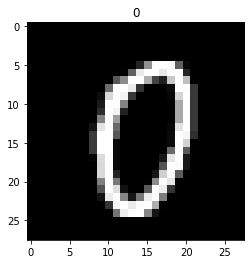

In [8]:
plt.imshow(train.train_data.data[1000], cmap='gray')
plt.title('%i' % train.targets[1000])
plt.show()

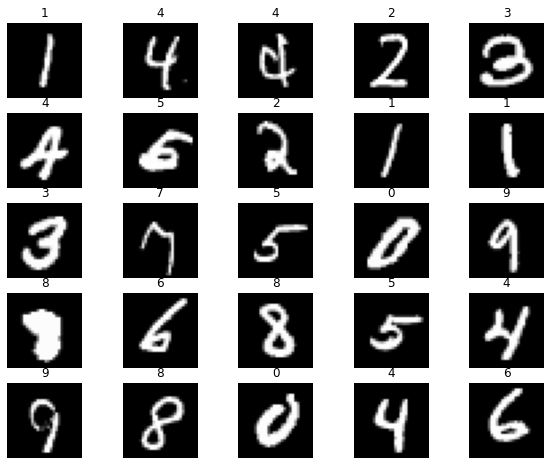

In [9]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train), size=(1,)).item()
    img, label = train[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [32]:
batch_size = 100
n_iters = 3000
#num_epochs = n_iters / (len(train_dataset) / batch_size)
#num_epochs = int(num_epochs)

loaders = {
'train_loader' : torch.utils.data.DataLoader(dataset=train, 
                                           batch_size=batch_size, 
                                           shuffle=True,
                                           num_workers=1),

'test_loader' : torch.utils.data.DataLoader(dataset=test, 
                                          batch_size=batch_size, 
                                          shuffle=True,
                                          num_workers=1),
}
loaders

{'test_loader': <torch.utils.data.dataloader.DataLoader at 0x7f2223bc3990>,
 'train_loader': <torch.utils.data.dataloader.DataLoader at 0x7f2223bc38d0>}

In [11]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        
        # Convolution 1
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.relu1 = nn.ReLU()
        
        # Max pool 1
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
     
        # Convolution 2
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.relu2 = nn.ReLU()
        
        # Max pool 2
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        
        # Fully connected 1 (readout)
        self.fc1 = nn.Linear(32 * 7 * 7, 10) 
    
    def forward(self, x):
        # Convolution 1
        out = self.cnn1(x)
        out = self.relu1(out)
        
        # Max pool 1
        out = self.maxpool1(out)
        
        # Convolution 2 
        out = self.cnn2(out)
        out = self.relu2(out)
        
        # Max pool 2 
        out = self.maxpool2(out)
        
        # Resize
        # Original size: (100, 32, 7, 7)
        # out.size(0): 100
        # New out size: (100, 32*7*7)
        out = out.view(out.size(0), -1)

        # Linear function (readout)
        out = self.fc1(out)
        
        return out

In [12]:
model = CNNModel()
print(model)

CNNModel(
  (cnn1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1568, out_features=10, bias=True)
)


In [13]:
loss_function = nn.CrossEntropyLoss()

In [14]:
learning_rate = 0.01

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  

In [34]:
# Train the model
total_step = len(loaders['train_loader'])
total_step

600

In [36]:
iter = 0
num_epochs=10
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(loaders['train_loader']):
        # Load images
        images = images.requires_grad_()
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        
        # Forward pass to get output/logits
        outputs = model(images)
        
        # Calculate Loss: softmax --> cross entropy loss
        loss = loss_function(outputs, labels)
        
        # Getting gradients w.r.t. parameters
        loss.backward()
        
        # Updating parameters
        optimizer.step()
        
        iter += 1
        
        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in loaders['test_loader']:
                # Load images
                images = images.requires_grad_()
                
                # Forward pass only to get logits/output
                outputs = model(images)
                
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)
                
                # Total number of labels
                total += labels.size(0)
                
                # Total correct predictions
                correct += (predicted == labels).sum()
            
            accuracy = 100 * correct / total
            
            # Print Loss
            print('Epoch [{}/{}], Step [{}/{}], Iteration: {}, Loss: {:.4f}, Accuracy: {:.4f}'.format(epoch + 1, num_epochs, i + 1, total_step, iter, loss.item(), accuracy))

Epoch [1/10], Step [500/600], Iteration: 500, Loss: 0.08554668724536896, Accuracy: 98.20999908447266
Epoch [2/10], Step [400/600], Iteration: 1000, Loss: 0.07656237483024597, Accuracy: 98.30000305175781
Epoch [3/10], Step [300/600], Iteration: 1500, Loss: 0.042325425893068314, Accuracy: 98.43000030517578
Epoch [4/10], Step [200/600], Iteration: 2000, Loss: 0.09150636941194534, Accuracy: 98.45999908447266
Epoch [5/10], Step [100/600], Iteration: 2500, Loss: 0.08865096420049667, Accuracy: 98.19999694824219
Epoch [5/10], Step [600/600], Iteration: 3000, Loss: 0.03289296105504036, Accuracy: 98.63999938964844
Epoch [6/10], Step [500/600], Iteration: 3500, Loss: 0.09535500407218933, Accuracy: 98.56999969482422
Epoch [7/10], Step [400/600], Iteration: 4000, Loss: 0.06516891717910767, Accuracy: 98.68000030517578
Epoch [8/10], Step [300/600], Iteration: 4500, Loss: 0.11105810850858688, Accuracy: 98.41000366210938
Epoch [9/10], Step [200/600], Iteration: 5000, Loss: 0.02043473720550537, Accuracy

[[ 977    0    0    0    0    0    1    0    1    1]
 [   0 1130    2    0    0    0    1    1    1    0]
 [   0    1 1029    0    0    0    0    1    1    0]
 [   0    0    2 1005    0    3    0    0    0    0]
 [   0    0    0    0  974    0    1    1    1    5]
 [   1    0    1    4    0  884    1    0    0    1]
 [   1    2    0    1    1    7  944    0    2    0]
 [   0    2    6    1    0    0    0 1015    1    3]
 [   4    0    4    4    0    3    1    2  952    4]
 [   0    1    0    1    4    3    0    2    0  998]]


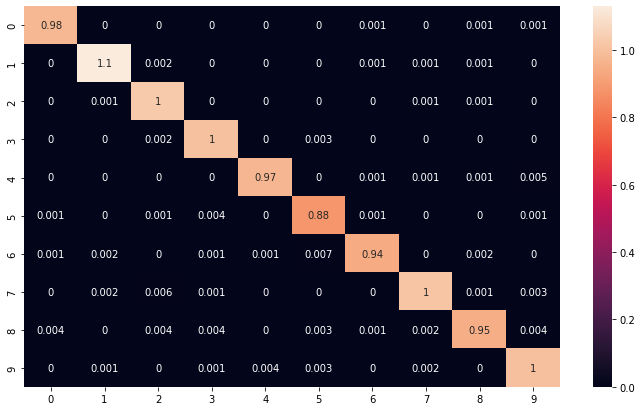

In [44]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import numpy as np

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in loaders['test_loader']:
        output = model(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
print(cf_matrix)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')

In [38]:
learning_rate = 0.01
momentum=0.9

optimizer_1 = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)  

In [40]:
iter = 0
num_epochs=10
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(loaders['train_loader']):
        # Load images
        images = images.requires_grad_()
        
        # Clear gradients w.r.t. parameters
        optimizer_1.zero_grad()
        
        # Forward pass to get output/logits
        outputs = model(images)
        
        # Calculate Loss: softmax --> cross entropy loss
        loss = loss_function(outputs, labels)
        
        # Getting gradients w.r.t. parameters
        loss.backward()
        
        # Updating parameters
        optimizer_1.step()
        
        iter += 1
        
        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in loaders['test_loader']:
                # Load images
                images = images.requires_grad_()
                
                # Forward pass only to get logits/output
                outputs = model(images)
                
                # Get predictions from the maximum value
                _, predicted = torch.max(outputs.data, 1)
                
                # Total number of labels
                total += labels.size(0)
                
                # Total correct predictions
                correct += (predicted == labels).sum()
            
            accuracy = 100 * correct / total
            
            # Print Loss
            print('Epoch [{}/{}], Step [{}/{}], Iteration: {}, Loss: {:.4f}, Accuracy: {:.4f}'.format(epoch + 1, num_epochs, i + 1, total_step, iter, loss.item(), accuracy))

Epoch [1/10], Step [500/600], Iteration: 500, Loss: 0.0255, Accuracy: 98.5700
Epoch [2/10], Step [400/600], Iteration: 1000, Loss: 0.0599, Accuracy: 98.7800
Epoch [3/10], Step [300/600], Iteration: 1500, Loss: 0.0472, Accuracy: 98.6800
Epoch [4/10], Step [200/600], Iteration: 2000, Loss: 0.0326, Accuracy: 98.6700
Epoch [5/10], Step [100/600], Iteration: 2500, Loss: 0.0313, Accuracy: 98.3900
Epoch [5/10], Step [600/600], Iteration: 3000, Loss: 0.0582, Accuracy: 98.8500
Epoch [6/10], Step [500/600], Iteration: 3500, Loss: 0.0181, Accuracy: 98.8700
Epoch [7/10], Step [400/600], Iteration: 4000, Loss: 0.0670, Accuracy: 99.0000
Epoch [8/10], Step [300/600], Iteration: 4500, Loss: 0.0707, Accuracy: 98.9600
Epoch [9/10], Step [200/600], Iteration: 5000, Loss: 0.0109, Accuracy: 98.8300
Epoch [10/10], Step [100/600], Iteration: 5500, Loss: 0.0043, Accuracy: 99.0700
Epoch [10/10], Step [600/600], Iteration: 6000, Loss: 0.0122, Accuracy: 99.0800
